In [1]:
# Load the data
import pandas as pd

# Load the data
df = pd.read_csv('H:\database.csv')  # replace with your csv file path

# Separate the features (X) and the target variable (y)
X = df.drop('Penetration rate', axis=1)  # replace 'penetration_rate' with your actual target column name
y = df['Penetration rate']  # replace 'penetration_rate' with your actual target column name

In [2]:
# Preprocess the data
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Define the preprocessing pipelines
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


In [3]:
# Feature selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Fit a random forest model to the training data
rf = RandomForestRegressor(random_state=42)
rf.fit(preprocessor.fit_transform(X_train), y_train)

# Use SelectFromModel to select features whose importance is greater than the mean importance
selector = SelectFromModel(rf, threshold='mean', prefit=True)
X_train_selected = selector.transform(preprocessor.transform(X_train))
X_test_selected = selector.transform(preprocessor.transform(X_test))


In [4]:
# Feature Engineering
# Create a new feature that captures the interaction between Hardness and Percussion pressure
df['Hardness_Percussion'] = df['Hardness'] * df['Percussion pressure']

# Rerun the model with the new feature


In [5]:
# Model Tuning



In [6]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and the values we want to test
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}

# Run the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_selected, y_train)

# Get the best parameters
best_params = grid_search.best_params_


In [7]:
# Train the final model
# Train the final model
rf_final = RandomForestRegressor(n_estimators=best_params['n_estimators'], 
                                 max_depth=best_params['max_depth'], 
                                 random_state=42)
rf_final.fit(X_train_selected, y_train)


RandomForestRegressor(max_depth=30, random_state=42)

In [8]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_test_pred = rf_final.predict(X_test_selected)

# Calculate and print the RMSE and R^2 scores
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)
print(f'RMSE: {rmse}, R^2: {r2}')


RMSE: 0.13397446831314913, R^2: 0.9571769421228721


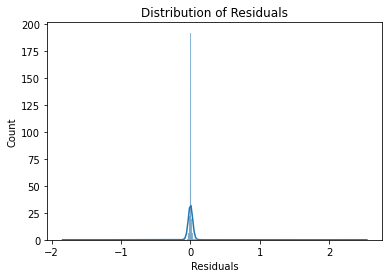

In [9]:
# Residual Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_test_pred

# Plot the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


In [10]:
# Get the transformed feature names
transformed_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names(categorical_features)
all_features = list(numerical_features) + list(transformed_features)

# Select the features
selected_features = [feature for (feature, support) in zip(all_features, selector.get_support()) if support]

# Create a DataFrame with the features and their respective importance scores
importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_final.feature_importances_
})

# Sort the DataFrame by the importance scores
importances = importances.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importances)


                     Feature  Importance
6                   Hardness    0.772346
1        Percussion pressure    0.062120
17  Time_2017-02-10T08:17:07    0.023220
2              Feed pressure    0.021596
15  Time_2017-02-10T08:16:54    0.017946
4          Rotation pressure    0.014185
0                      Depth    0.013993
9         Hole id_07b4bd5a9d    0.012548
5         Dampening pressure    0.010849
3         Flush air pressure    0.010331
8                     HoleNo    0.009501
31  Time_2017-02-10T10:40:21    0.004889
16  Time_2017-02-10T08:16:55    0.004026
11        Hole id_5b88eb1e23    0.003034
34  Time_2017-02-10T14.31.45    0.002988
29  Time_2017-02-10T10:40:05    0.002888
30  Time_2017-02-10T10:40:20    0.002078
10        Hole id_35f0f14168    0.001603
21  Time_2017-02-10T08:42:25    0.001382
35  Time_2017-02-10T14.31.46    0.001197
24  Time_2017-02-10T08:49:41    0.001195
7                      Salve    0.000751
23  Time_2017-02-10T08:42:27    0.000738
13        Hole i